## Why Spark for Machine Learning?
- Spark is a unified analytics engine that provides an ecosystem for data ingestion, feature engineering, model training, and deployment. Without Spark, developers would
need many disparate tools to accomplish this set of tasks, and might still struggle with
scalability.
<br>
- Spark has two machine learning packages: <b>spark.mllib</b> and <b>spark.ml</b>. <b>spark.mllib</b>
is the original machine learning API, <b>based on the RDD API</b> (which has been in
maintenance mode since Spark 2.0), while <b>spark.ml</b> is the <b><i>newer</b></i> API, <b>based on DataFrames</b>. We will focus on using the <b>spark.ml</b> package and how to
design machine learning pipelines in Spark. However, we use “MLlib” as an umbrella
term to refer to both machine learning library packages in Apache Spark.
- With spark.ml , data scientists can use one ecosystem for their data preparation and
model building, without the need to downsample their data to fit on a single
machine.
- Spark.ml focuses on O(n) scale-out, where the model scales linearly with
the number of data points you have, so it can scale to massive amounts of data.

## Designing Machine Learning Pipelines
- The concept of
pipelines is common across many ML frameworks as a way to organize a series of
operations to apply to your data.
- In <b>MLlib, the Pipeline API</b> provides a high-level API
built on top of DataFrames to organize your machine learning workflow.
- The Pipeline API is composed of a series of <b>transformers and estimators</b>.

<b>Throughout this session, we will use the San Francisco housing data set from Inside
Airbnb. It contains information about Airbnb rentals in San Francisco, such as the
number of bedrooms, location, review scores, etc., and our goal is to build a model to
predict the nightly rental prices for listings in that city. This is a regression problem,
because price is a continuous variable. We will guide you through the workflow a data
scientist would go through to approach this problem, including feature engineering,building models, hyperparameter tuning, and evaluating model performance.</b><br><br>
<b><font color='red'>Note: </font></b>This
data set is quite messy and can be difficult to model (like most real-world data sets!),
so if you are experimenting on your own, don’t feel bad if your early models aren’t
great.

The intent of this session is not to show you every API in MLlib, but rather to equip
you with the skills and knowledge to get started with using MLlib to build end-to-end
pipelines.

## MLlib terminology:

### Transformer
- Accepts a DataFrame as input, and returns a new DataFrame with one or more
columns appended to it. 
- Transformers do not learn any parameters from your data and simply apply rule-based transformations to either
    - <b>prepare data for model training</b> or
    - <b>generate predictions using a trained MLlib model.</b> 
- They have <b>a .transform()</b> method.

### Estimator
- <b>Learns (or “fits”)</b> parameters from your DataFrame via <b>a .fit()</b> method and
returns a Model , which is a transformer.

### Pipeline
- Organizes a series of transformers and estimators into a single model. While
pipelines themselves are estimators, the output of pipeline.fit() returns a Pipeline Model , a transformer.

## Data Preparation and Exploration

### The used data is slightly preprocessed as follow:   <i><font color='green'>(you can try by yourself)</font><i/>
- Outliers are removed (e.g., Airbnbs posted for $0/night).
- All integers are converted to doubles.
- An informative subset of the more than one hundred fields.
- For any missing numerical values in the data columns, the median value is imputed and added
an indicator column (the column name followed by _na , such as bedrooms_na ). This way the ML model or human analyst can interpret any value in that column as an imputed value, not a true value. 

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName('Mllib_Airbnb').getOrCreate()

In [ ]:
filepath = '/home/hhhhh/Data/sf-airbnb/sf-airbnb-clean.parquet/'

In [ ]:
airbnbDF = spark.read.parquet(filepath)

In [ ]:
airbnbDF.printSchema()

root
 |-- host_is_superhost: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- review_scores_accuracy: double (nullable = true)
 |-- review_scores_cleanliness: double (nullable = true)
 |-- review_scores_checkin: double (nullable = true)
 |-- review_scores_communication: double (nullable = true

In [ ]:
airbnbDF.select("neighbourhood_cleansed", "room_type", "bedrooms", "bathrooms",
"number_of_reviews", "price").show(5)

+----------------------+---------------+--------+---------+-----------------+-----+
|neighbourhood_cleansed|      room_type|bedrooms|bathrooms|number_of_reviews|price|
+----------------------+---------------+--------+---------+-----------------+-----+
|      Western Addition|Entire home/apt|     1.0|      1.0|            180.0|170.0|
|        Bernal Heights|Entire home/apt|     2.0|      1.0|            111.0|235.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|             17.0| 65.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|              8.0| 65.0|
|      Western Addition|Entire home/apt|     2.0|      1.5|             27.0|785.0|
+----------------------+---------------+--------+---------+-----------------+-----+
only showing top 5 rows



In [ ]:
airbnbDF.createOrReplaceTempView('airbnbDF_view')
spark.sql('SELECT neighbourhood_cleansed, room_type, bedrooms, bathrooms,number_of_reviews, price FROM airbnbDF_view').show(5)

+----------------------+---------------+--------+---------+-----------------+-----+
|neighbourhood_cleansed|      room_type|bedrooms|bathrooms|number_of_reviews|price|
+----------------------+---------------+--------+---------+-----------------+-----+
|      Western Addition|Entire home/apt|     1.0|      1.0|            180.0|170.0|
|        Bernal Heights|Entire home/apt|     2.0|      1.0|            111.0|235.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|             17.0| 65.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|              8.0| 65.0|
|      Western Addition|Entire home/apt|     2.0|      1.5|             27.0|785.0|
+----------------------+---------------+--------+---------+-----------------+-----+
only showing top 5 rows



### Our goal is to predict the price per night for a rental property, given our features.

### Creating Training and Test Data Sets

In [ ]:
trainDF, testDF = airbnbDF.randomSplit([.8,.2],seed=42)
print(f"There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set")

There are 5780 rows in the training set, and 1366 in the test set


- But what happens if we change the number of executors in our Spark cluster? The
Catalyst optimizer determines the optimal way to partition your data as a function of
your cluster resources and size of your data set. Given that data in a Spark DataFrame
is row-partitioned and each worker performs its split independently of the other
workers, if the data in the partitions changes, then the result of the split (by random
Split() ) won’t be the same.
- While you could fix your cluster configuration and your seed to ensure that you get
consistent results, it is recommended to split your data once, then write it out to
its own train/test folder so you don’t have these reproducibility issues.

<b><font color = 'red'>Note: </font>
During your exploratory analysis, you should cache the training
data set because you will be accessing it many times throughout the
machine learning process.</b>

### Preparing Features with Transformers
- Now that we have split our data into training and test sets, let’s prepare the data to
build a linear regression model predicting price given the number of bedrooms.
-  Linear regression (like many other algorithms in
Spark) requires that all the input features are contained within a single vector in your
DataFrame. Thus, we need to transform our data.
- Transformers in Spark accept a DataFrame as input and return a new DataFrame
with one or more columns appended to it. They do not learn from your data, but
apply rule-based transformations using the transform() method.
- For the task of putting all of our features into a single vector, we will use the <b>VectorAssembler</b> transformer. 
- VectorAssembler takes a list of input columns and creates a new DataFrame with an additional column, which we will call features . It combines the values of those input columns into a single vector.

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
vecAssembler = VectorAssembler(inputCols=['bedrooms'],outputCol='features')

In [ ]:
vecAssembler

VectorAssembler_cfc9ceb9b339

In [ ]:
vectTrainDF = vecAssembler.transform(trainDF)

In [ ]:
vectTrainDF.printSchema()

root
 |-- host_is_superhost: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- review_scores_accuracy: double (nullable = true)
 |-- review_scores_cleanliness: double (nullable = true)
 |-- review_scores_checkin: double (nullable = true)
 |-- review_scores_communication: double (nullable = true

In [ ]:
vectTrainDF.select('bedrooms','features','price').show(5)

+--------+--------+-----+
|bedrooms|features|price|
+--------+--------+-----+
|     1.0|   [1.0]|200.0|
|     1.0|   [1.0]|130.0|
|     1.0|   [1.0]| 95.0|
|     1.0|   [1.0]|250.0|
|     3.0|   [3.0]|250.0|
+--------+--------+-----+
only showing top 5 rows



### Using Estimators to Build Models
- After setting up our vectorAssembler , we have our data prepared and transformed into a format that our linear regression model expects.
- In Spark, <b>LinearRegression</b> is a type of <b>estimator</b>—it takes in a <b>DataFrame</b> and returns a <b>Model</b>.
- Estimators learn parameters from your data, have an <b>estimator_name.fit()</b> method.

<b><font color = 'red'>Note: </font>Estimators are eagerly evaluated (i.e., kick off Spark jobs), whereas transformers are lazily evaluated.</b>

In [5]:
from pyspark.ml.regression import LinearRegression

In [ ]:
lr = LinearRegression(featuresCol='features',labelCol='price')
lrModel = lr.fit(vectTrainDF)

- <b>lr.fit()</b> returns a <b>LinearRegressionModel ( lrModel )</b>, which is a <b>transformer</b>. In other words, the output of an estimator’s <b>fit()</b> method is a <b>transformer</b>.
- Once the estimator has learned the parameters, the transformer can apply these parameters to new data points to generate predictions.

In [ ]:
m =round(lrModel.coefficients[0],2)
b = round(lrModel.intercept,2)
print(f"The formula for the linear regression line is \033[1m price = {b} + {m}*bedrooms \033[0m")

The formula for the linear regression line is  price = 47.51 + 123.68*bedrooms 


## Creating a Pipeline
- If we want to apply our model to our test set, then we need to prepare that data in the same way as the training set (i.e., pass it through the vector assembler).
- Oftentimes data preparation pipelines will have multiple steps, and it becomes cumbersome to remember not only which steps to apply, but also the ordering of the steps.
- This is the motivation for the Pipeline API: you simply specify the stages you want your data to pass through, in order, and Spark takes care of the processing for you.
- They provide the user with better code reusability and organization.
- In Spark, <b>Pipelines are estimators, whereas PipelineModels—fitted Pipelines—are transformers</b>.

In [ ]:
# Building the pipeline
from pyspark.ml import Pipeline

In [ ]:
pipeline = Pipeline(stages=[vecAssembler,lr])
pipelineModel = pipeline.fit(trainDF)

- Another advantage of using the Pipeline API is that it determines which stages are <b>estimators/transformers</b> for you, so you don’t have to worry about specifying <b>name.fit()</b> versus <b>name.transform()</b> for each of the stages.
- Since pipelineModel is a transformer, it is straightforward to apply it to our test data set too:

In [ ]:
predDF = pipelineModel.transform(testDF)

In [ ]:
predDF.select("bedrooms",'features','price','prediction').show(10)

+--------+--------+------+------------------+
|bedrooms|features| price|        prediction|
+--------+--------+------+------------------+
|     1.0|   [1.0]|  85.0|171.18598011578285|
|     1.0|   [1.0]|  45.0|171.18598011578285|
|     1.0|   [1.0]|  70.0|171.18598011578285|
|     1.0|   [1.0]| 128.0|171.18598011578285|
|     1.0|   [1.0]| 159.0|171.18598011578285|
|     2.0|   [2.0]| 250.0|294.86172649777757|
|     1.0|   [1.0]|  99.0|171.18598011578285|
|     1.0|   [1.0]|  95.0|171.18598011578285|
|     1.0|   [1.0]| 100.0|171.18598011578285|
|     1.0|   [1.0]|2010.0|171.18598011578285|
+--------+--------+------+------------------+
only showing top 10 rows



## Multivariable Linear Regression
In the pipeline we just created, we only had two stages, and our linear regression
model only used one feature. Let’s take a look at how to build a slightly more complex
pipeline that incorporates all of our numeric and categorical features.

### One-hot encoding
- Most machine learning models in MLlib expect numerical values as input, represented as vectors.
- To convert categorical values into numeric values, we can use a
technique called <b>one-hot encoding (OHE)</b>.
- Suppose we have a column called Animal
and we have three types of animals: Dog , Cat , and Fish . We can’t pass the string types
into our ML model directly, so we need to assign a numeric mapping, such as this:<br>
<center><b>Animal = {"Dog", "Cat", "Fish"}</b></center>
<center><b>"Dog" = 1, "Cat" = 2, "Fish" = 3</b></center>
- However, using this approach we’ve introduced some <b>spurious relationships</b> into our
data set that weren’t there before. For example, <b>why did we assign Cat twice the value
of Dog ?</b> The numeric values we use should not introduce any relationships into our
data set. Instead, we want to create a separate column for every distinct value in our
Animal column:
<center><b>"Dog" = [ 1, 0, 0]</b></center>
<center><b>"Cat" = [ 0, 1, 0]</b></center>
<center><b>"Fish" = [0, 0, 1]</b></center>
If the animal is a dog, it has a one in the first column and zeros elsewhere. If it is a cat,
it has a one in the second column and zeros elsewhere. The ordering of the columns
is irrelevant. It is as <b>pandas.get_dummies()</b>.<br>
If we had a zoo of <b>300 animals</b>, would <b>OHE</b> massively increase consumption of memory/compute resources? <b><i>Not with Spark!</i></b> Spark internally uses a <b>SparseVector</b> when
the majority of the entries are 0 , <i>as is often the case after OHE</i>, so it does not waste
space storing 0 values. Let’s take a look at an example to better understand how
SparseVector s work:
<center><b>DenseVector(0, 0, 0, 7, 0, 2, 0, 0, 0, 0)</b></center>
<center><b>SparseVector(10, [3, 5], [7, 2])</b></center>
The <b>DenseVector</b> in this example contains 10 values, all but 2 of which are 0 . To create a SparseVector , we need to keep track of the size of the vector, the indices of the
nonzero elements, and the corresponding values at those indices. <i>In this example the
size of the vector is 10, there are two nonzero values at indices 3 and 5, and the corresponding values at those indices are 7 and 2.</i><br>
<br>A common approach to one-hot encode your data with Spark is to use the <b>StringIndexer and OneHotEncoder</b>. With this approach, the first step is to
apply the <b>StringIndexer <i>estimator<i></b> to convert categorical values into category indices. These category indices are ordered by label frequencies, so the most frequent
label gets index 0, which provides us with reproducible results across various runs of
the same data.<br>
Once you have created your category indices, you can pass those as input to the
<b>OneHotEncoder</b>. The <b>OneHotEncoder<i> (estimator)</i></b> maps a column of category indices to a column of binary vectors. 

<b><font color='red'>Note: </font> In our data set, any column of type string is treated as a categorical feature, but sometimes you might have numeric features you want treated as categorical or vice versa.</b>

In [6]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [ ]:
trainDF.dtypes

In [ ]:
categoricalCols = [field for (field, dataType) in trainDF.dtypes
                   if dataType == "string"]

In [ ]:
categoricalCols

In [ ]:
indexOutputCols = [x + "_Index" for x in categoricalCols]
indexOutputCols

In [ ]:
oheOutputCols = [x + "_OHE" for x in categoricalCols]
oheOutputCols

In [ ]:
stringIndexer = StringIndexer(inputCols=categoricalCols,
                             outputCols=indexOutputCols,
                             handleInvalid='skip')
oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                          outputCols=oheOutputCols)

In [ ]:
numericCols = [field for (field,dataType) in trainDF.dtypes
              if ((dataType=='double')& (field!='price'))]
numericCols

In [ ]:
assemblerInputs = oheOutputCols + numericCols
assemblerInputs

In [ ]:
vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')

- Now you might be wondering, “How does the StringIndexer handle new categories that appear in the test data set, but not in the training data set?” 
- There is a handleInvalid parameter that specifies how you want to handle them. 
- The option are <b><i>skip (filter out rows with invalid data), error (throw an error), or keep (put invalid data in a special additional bucket, at index numLabels )</b></i>. 
- For this example, we just skipped the invalid records.
- <b>For more information and detailed explanation check the following resources:</b><br>
https://stackoverflow.com/questions/34681534/spark-ml-stringindexer-handling-unseen-labels<br>
https://spark.apache.org/docs/latest/ml-features.html#stringindexer

In [ ]:
lr = LinearRegression(labelCol='price',featuresCol='features')
pipeline =Pipeline(stages = [stringIndexer,oheEncoder,vecAssembler,lr])

In [ ]:
pipelineModel = pipeline.fit(trainDF)

In [ ]:
predDF = pipelineModel.transform(testDF)

In [ ]:
predDF.select('features','price','prediction').show(5)

In [ ]:
predDF.select('features').show(2,truncate=False)

### Model Evaluation

In [ ]:
# Using RMSE
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
regressionEvaluator = RegressionEvaluator(predictionCol='prediction',
                                         labelCol='price',
                                         metricName='rmse')

In [ ]:
rmse = regressionEvaluator.evaluate(predDF)
#print("RMSE is {:.1f}".format(rmse))
print(f"RMSE is {rmse:.1f}")

RMSE is 220.6


In [ ]:
# Using R^2
r2 = RegressionEvaluator(predictionCol='prediction',
                                         labelCol='price',
                                         metricName='r2').evaluate(predDF)
print(f"R2 is {r2}")

R2 is 0.16043316698848087


- Our R2 is positive, but it’s very close to 0. One of the reasons why our model is not performing too well is because our label, price , appears to be <b>log-normally distributed</b>.
- If a distribution is log-normal, it means that if we take the logarithm of the
value, the result looks like a normal distribution.
- Price is often log-normally distributed. If you think about rental prices in San Francisco, most cost around $200 per
night, but there are some that rent for thousands of dollars a night!

In [ ]:
price  = airbnbDF.select('price').toPandas()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='price', ylabel='Count'>

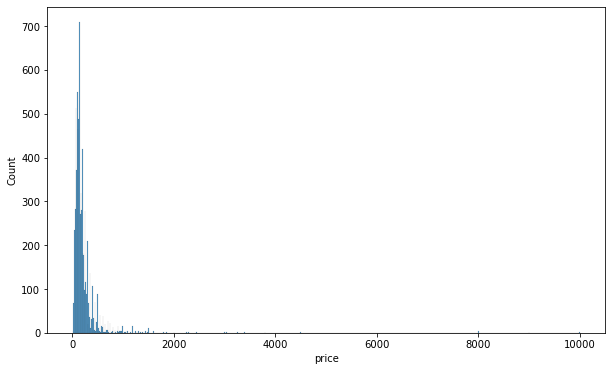

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(price['price'])

In [1]:
import math

In [ ]:
price['log_price']= price['price'].apply(math.log)

In [ ]:
price.head()

,price,log_price
0,170.0,5.135798
1,235.0,5.459586
2,65.0,4.174387
3,65.0,4.174387
4,785.0,6.665684


<AxesSubplot:xlabel='log_price', ylabel='Count'>

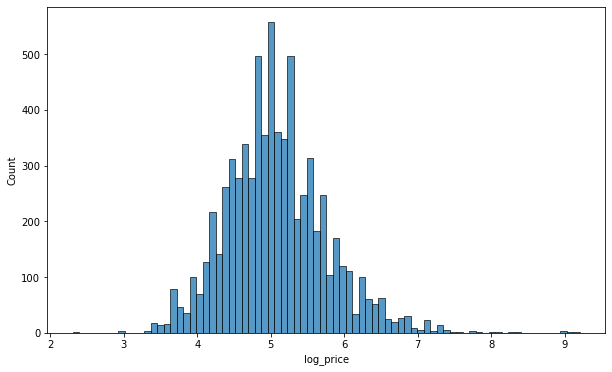

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(price['log_price'])

## Exercise:
### Try building a model to predict price on the log scale, then exponentiate the prediction to get it out of log scale and evaluate your model.

In [2]:
math.exp(1)

2.718281828459045

### Saving and Loading Models

In [ ]:
# Saving the model
pipelinePath = "lr-pipeline-model"
pipelineModel.write().overwrite().save(pipelinePath)

In [ ]:
# Loading the model
from pyspark.ml import PipelineModel
savedPipelineModel = PipelineModel.load(pipelinePath)

## Decision trees
As an off-the-shelf solution, decision trees are well suited to data mining. They are
relatively fast to build, highly interpretable, and scale-invariant (i.e., standardizing or
scaling the numeric features does not change the performance of the tree). <b>So what is
a decision tree?</b>

- <b>A decision tree</b> is a series of if-then-else rules learned from your data for <b>classification
or regression tasks.</b>
- Suppose we are trying to build a model to predict whether or not
someone will accept a job offer, and the features comprise salary, commute time, free
coffee, etc. If we fit a decision tree to this data set, we might get a model that looks
like
![image.png](attachment:image.png)

- The depth of a decision tree is the longest path from the root node to any given leaf
node. In this figure, the depth is three.
- Trees that are very deep are prone to overfitting, or memorizing noise in your training data set, but trees that are too shallow will
underfit to your data set (i.e., could have picked up more signal from the data).

<b><i>
- For decision trees, you don’t have to worry about standardizing or scaling your input features, because this has no impact on the splits—but you do have to be careful about how you prepare your categorical features.
- Tree-based methods can naturally handle categorical variables. In spark.ml , you just
need to pass the categorical columns to the StringIndexer , and the decision tree can
take care of the rest.</b></i>

### Let’s fit a decision tree to our data set:

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
dt = DecisionTreeRegressor(labelCol='price')

In [ ]:
# Filter for just numeric columns (and exclude price, our label)
numericCols =[field for (field,dataType) in trainDF.dtypes 
              if ((dataType=='double')&(field!='price'))]

In [ ]:
# Combine output of StringIndexer defined above and numeric columns
assemblerInputs = indexOutputCols + numericCols

In [ ]:
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [ ]:
# Combine stages into pipeline
stages = [stringIndexer, vecAssembler, dt]

In [ ]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(trainDF) # This line should error

IllegalArgumentException: requirement failed: DecisionTree requires maxBins (= 32) to be at least as large as the number of values in each categorical feature, but categorical feature 3 has 36 values. Consider removing this and other categorical features with a large number of values, or add more training examples.

- We can see that there is an issue with the <b>maxBins</b> parameter. What does that parameter do? 
- <b>maxBins</b> determines the number of bins into which your continuous features are discretized, or split. This discretization step is crucial for performing distributed training. 
- There is no maxBins parameter in <b>scikit-learn</b> because all of the data and the model reside on a single machine. 
- In Spark, however, workers have all the columns of the data, but only a subset of the rows. Thus, when communicating about which features and values to split on, we need to be sure they’re all talking about the same split values, which we get from the common discretization set up at training time.

![image.png](attachment:image.png)

- Every worker has to compute summary statistics for every feature and every possible split point, and those statistics will be aggregated across the workers.
- MLlib requires maxBins to be large enough to handle the discretization of the categorical columns.

In [ ]:
trainDF.printSchema()

root
 |-- host_is_superhost: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- review_scores_accuracy: double (nullable = true)
 |-- review_scores_cleanliness: double (nullable = true)
 |-- review_scores_checkin: double (nullable = true)
 |-- review_scores_communication: double (nullable = true

In [ ]:
trainDF.select('neighbourhood_cleansed').distinct().count()

36

In [ ]:
# We do not have to rrdefine it completely we can just setMaxBins 
dt.setMaxBins(40)
pipelineModel = pipeline.fit(trainDF)

In [ ]:
"""
Now that we have successfully built our model, 
we can extract the if-then-else rules learned by the decision tree:
""" 
dtModel = pipelineModel.stages[-1]
print(dtModel.toDebugString)

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_9d5b6ac076a3, depth=5, numNodes=47, numFeatures=33
  If (feature 12 <= 2.5)
   If (feature 12 <= 1.5)
    If (feature 5 in {1.0,2.0})
     If (feature 4 in {0.0,1.0,3.0,5.0,9.0,10.0,11.0,13.0,14.0,16.0,18.0,24.0})
      If (feature 3 in {0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0})
       Predict: 104.23992784125075
      Else (feature 3 not in {0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0})
       Predict: 250.7111111111111
     Else (feature 4 not in {0.0,1.0,3.0,5.0,9.0,10.0,11.0,13.0,14.0,16.0,18.0,24.0})
      If (feature 3 in {0.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,27.0,33.0,35.0})
       Predict: 151.94179894179894
      Else (feat

- You’ll notice that it’s possible to split on the
same feature more than once (e.g., feature 12), but at different split values. Also
notice the difference between how the decision tree splits on numeric features versus
categorical features: for numeric features it checks if the value is less than or equal to
the threshold, and for categorical features it checks if the value is in that set or not.

In [ ]:
"""
We can also extract the feature importance scores from our model to see the most
important features:
"""
import pandas as pd
featureImp = pd.DataFrame(list(zip(vecAssembler.getInputCols(),dtModel.featureImportances)),
                         columns=['feature','importance'])
featureImp.sort_values(by='importance',ascending=False)

,feature,importance
12,bedrooms,0.283406
1,cancellation_policy_Index,0.167893
2,instant_bookable_Index,0.140081
4,property_type_Index,0.128179
15,number_of_reviews,0.126233
3,neighbourhood_cleansed_Index,0.056200
9,longitude,0.038810
14,minimum_nights,0.029473
13,beds,0.015218
5,room_type_Index,0.010905


In [ ]:
predDF = pipelineModel.transform(testDF)

In [ ]:
predDF.select('features','price','prediction').show(5)

+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|(33,[1,3,4,7,8,9,...| 85.0|131.96658097686375|
|[0.0,2.0,0.0,15.0...| 45.0|104.23992784125075|
|[0.0,2.0,0.0,15.0...| 70.0|104.23992784125075|
|(33,[1,3,5,7,8,9,...|128.0|104.23992784125075|
|(33,[1,3,4,5,7,8,...|159.0|104.23992784125075|
+--------------------+-----+------------------+
only showing top 5 rows



In [ ]:
# Using R^2
r2 = RegressionEvaluator(predictionCol='prediction',
                                         labelCol='price',
                                         metricName='r2').evaluate(predDF)
print(f"R2 is {r2}")

R2 is -1.5696388432265533


## Random forests
- Ensembles work by taking a democratic approach. 
- Imagine there are many M&Ms in
a jar. You ask one hundred people to guess the number of M&Ms, and then take the
average of all the guesses. The average is probably closer to the true value than most
of the individual guesses. 
- That same concept applies to machine learning models. If
you build many models and combine/average their predictions, they will be more
robust than those produced by any individual model.

<b>Random forests</b> are an ensemble of decision trees with two key tweaks:

### Bootstrapping samples by rows
- <i><b>Bootstrapping</b></i> is a technique for simulating new data by sampling with replacement from your original data. Each decision tree is trained on a different bootstrap sample of your data set, which produces slightly different decision trees,
and then you aggregate their predictions. This technique is known as bootstrap
aggregating, or bagging. In a typical random forest implementation, each tree
samples the same number of data points with replacement from the original data
set, and that number can be controlled through the subsamplingRate parameter.

![image.png](attachment:image.png)

### Random feature selection by columns
- The main drawback with bagging is that the trees are all highly correlated, and
thus learn similar patterns in your data. To mitigate this problem, each time you
want to make a split you only consider a random subset of the columns (1/3 of
the features for RandomForestRegressor and $\sqrt{no. features}$ for RandomForestClassifier). Due to this randomness you introduce, you typically want each tree to
be quite shallow. You might be thinking: each of these trees will perform worse
than any single decision tree, so how could this approach possibly be better? It
turns out that each of the trees learns something different about your data set,
and combining this collection of “weak” learners into an ensemble makes the forest much more robust than a single decision tree.

![image.png](attachment:image.png)

### The APIs for random forests and decision trees are similar, and both can be applied to regression or classification tasks:

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(labelCol='price',maxBins=40,seed=42)

- Once you’ve trained your random forest, you can pass new data points through the
different trees trained in the ensemble.
- If you build a random forest it passes the
test point through each of the trees in the forest and  simply averages those predictions.
- Even though each of these trees is less performant
than any individual decision tree, the collection (or ensemble) actually provides a
more robust model.

<b><i><font color='blue'>Random forests truly demonstrate the power of distributed machine learning with
Spark, as each tree can be built independently of the other trees (e.g., you do not need
to build tree 3 before you build tree 10). Furthermore, within each level of the tree,
you can parallelize the work to find the optimal splits.</font></i></b>

## Exercise
- Build the pipeline using <b><i>RandomForestRegressor</i></b> and evaluate the model performance.
- Perform data preparation steps.
    1. StringIndexer.
    2. Columns selection.
    3. VectorAssembler.
    4. Model Creation.
    5. Combine stages into pipeline.
    6. Model Evaluation.

## Hyperparameter Tuning

### So how do we determine what the optimal number of trees in our random forest or the max depth of those trees should be? This process is called hyperparameter tuning.
- In contrast to a parameter, a hyperparameter is a value that controls the learning pro‐
cess or structure of your model, and it is not learned during training.
- Both the num‐
ber of trees and the max depth are examples of hyperparameters you can tune for
random forests.

## k-Fold Cross-Validation
- Which data set should we use to determine the optimal hyperparameter values? If we
use the training set, then the model is likely to overfit, or memorize the nuances of
our training data. This means it will be less likely to generalize to unseen data. But if
we use the test set, then that will no longer represent “unseen” data, so we won’t be
able to use it to verify how well our model generalizes. Thus, we need another data set
to help us determine the optimal hyperparameters: <b>the validation data set.</b>
- For example, instead of splitting our data into an <b>80/20 train/test split</b>, as we did earlier, we can do a <b>60/20/20 split</b> to generate <b>training, validation, and test data sets</b>,
respectively.
- We can then build our model on the training set, evaluate performance
on the validation set to select the best hyperparameter configuration, and apply the
model to the test set to see how well it performs on new data.
- However, one of the
downsides of this approach is that we lose <b>25%</b> of our training data <b>(80% -> 60%)</b>,
which could have been used to help improve the model. This motivates the use of the
<b>k-fold cross-validation</b> technique to solve this problem.
- With this approach, instead of splitting the data set into separate training, validation,
and test sets, we split it into training and test sets as before—but we use the training
data for both training and validation. To accomplish this, we split our training data
into <b>k subsets, or “folds” (e.g., three)</b>. Then, for a given hyperparameter configuration,
we train our model on <b>k–1</b> folds and evaluate on the remaining fold, repeating this
process <b>k times</b>.
![image.png](attachment:image.png)
- As this figure shows, if we split our data into three folds, our model is first trained on
the first and second folds (or splits) of the data, and evaluated on the third fold. We
then build the same model with the same hyperparameters on the first and third folds of the data, and evaluate its performance on the second fold.
- Lastly, we build the model on the second and third folds and evaluate it on the first fold. We then average
the performance of those <b>three (or k)</b> validation data sets as a proxy of how well this
model will perform on unseen data, as every data point had the chance to be part of
the validation data set exactly once.
- Next, we repeat this process for all of our different hyperparameter configurations to identify the optimal one.
- Determining the search space of your hyperparameters can be difficult, and often
doing a random search of hyperparameters outperforms a structured grid search.

### To perform a hyperparameter search in Spark, take the following steps :
1. Define the estimator you want to evaluate.
2. Specify which hyperparameters you want to vary, as well as their respective values, using the ParamGridBuilder.
3. Define an evaluator to specify which metric to use to compare the various
models.
4. Define an evaluator to specify which metric to use to compare the various
models.

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,vecAssembler,rf])

- For our <b>ParamGridBuilder</b> , we’ll vary our <b>maxDepth</b> to be <b>2, 4, or 6</b> and <b>numTrees (the number of trees in our random forest)</b> to be <b>10 or 100</b>. This will give us a grid of <b>6 (3 x 2)</b> different hyperparameter configurations in total:<br><b>
<center>(maxDepth=2, numTrees=10)</center>
<center>(maxDepth=2, numTrees=100)</center>
<center>(maxDepth=4, numTrees=10)</center>
<center>(maxDepth=4, numTrees=100)</center>
<center>(maxDepth=6, numTrees=10)</center>
<center>(maxDepth=6, numTrees=100)</center></b>

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

In [ ]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2,4,6])
             .addGrid(rf.numTrees, [10,100])
             .build())

- Now that we have set up our hyperparameter grid, we need to define how to evaluate
each of the models to determine which one performed best. For this task we will use
the <b>RegressionEvaluator</b> , and we’ll use <b>RMSE</b> as our metric of interest:

In [ ]:
evaluator = RegressionEvaluator(labelCol='price',
                              predictionCol='prediction',
                              metricName='rmse')

- We will perform our k-fold cross-validation using the <b>CrossValidator</b> , which accepts
an <b>estimator , evaluator , and estimatorParamMaps</b> so that it knows which model to
use, how to evaluate the model, and which hyperparameters to set for the model.
- We can also set the number of folds we want to split our data into <b>(numFolds=3)</b>, as well as setting a seed so we have reproducible splits across the folds (seed=42).

In [ ]:
from pyspark.ml.tuning import CrossValidator

In [ ]:
cv = CrossValidator(estimator=pipeline,
                   evaluator=evaluator,
                   estimatorParamMaps=paramGrid,
                   numFolds=3,
                   seed=42)

In [ ]:
%%time
cvModel = cv.fit(trainDF)

CPU times: user 2.92 s, sys: 520 ms, total: 3.44 s
Wall time: 1min 18s


- So, <b>how many models did we just train?</b> If you answered <b>18 (6 hyperparameter configurations x 3-fold cross-validation)</b>, <b><i>you’re close</i></b>. Once you’ve identified the optimal
hyperparameter configuration, <b>how do you combine those three (or k) models together?</b> While some models might be easy enough to average together, some are not. Therefore, <b>Spark retrains your model on the entire training data set once it has identified the optimal hyperparameter configuration</b>, so in the end <b>we trained 19 models</b>.

In [ ]:
# To inspect the results of the cross-validator, you can take a look at the avgMetrics :
list(zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics))

[({Param(parent='RandomForestRegressor_dc713eadf42a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
   Param(parent='RandomForestRegressor_dc713eadf42a', name='numTrees', doc='Number of trees to train (>= 1).'): 10},
  291.18226409247836),
 ({Param(parent='RandomForestRegressor_dc713eadf42a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
   Param(parent='RandomForestRegressor_dc713eadf42a', name='numTrees', doc='Number of trees to train (>= 1).'): 100},
  286.7714750274078),
 ({Param(parent='RandomForestRegressor_dc713eadf42a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4,
   Param(parent='RandomForestRegressor_dc713eadf42a', name='numTrees', doc='Number of trees to train (>= 1).'): 10},
  287.696324516081

## Optimizing Pipelines

In the preceding code, even though each of the models in the crossvalidator is technically independent, spark.ml actually trains the collection of models <b>sequentially rather than in parallel</b>. In Spark 2.3, a parallelism parameter was introduced to solve this problem. This parameter determines the number of models to train in parallel, which themselves are fit in parallel. <b>From the Spark Tuning Guide:</b><br><br>
<i><center>"The value of parallelism should be chosen carefully to maximize parallelism without exceeding cluster resources, and larger values may not always lead to improved performance. Generally speaking, a value up to 10 should be sufficient for most clusters."<center><i>


In [ ]:
%%time
cvModel = cv.setParallelism(4).fit(trainDF)

CPU times: user 2.74 s, sys: 565 ms, total: 3.31 s
Wall time: 1min


- There’s another trick we can use to speed up model training:
putting the cross-validator inside the pipeline.
- Every time the cross-validator evaluates the pipeline, it runs
through every step of the pipeline for each model, even if some of the steps don’t
change, such as the StringIndexer .
- By reevaluating every step in the pipeline, we are
learning the same StringIndexer mapping over and over again, even though it’s not
changing.

In [ ]:
cv = CrossValidator(estimator=rf,
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=3,
                    parallelism=4,
                    seed=42)
pipeline = Pipeline(stages=[stringIndexer, vecAssembler, cv])

In [ ]:
%%time
pipelineModel = pipeline.fit(trainDF)

CPU times: user 1.24 s, sys: 378 ms, total: 1.62 s
Wall time: 44.5 s


#### References:
    1- https://spark.apache.org/docs/latest/sql-programming-guide.html
    2- https://spark.apache.org/    